## centroid extraction

In [1]:
import librosa,librosa.display

y, sr = librosa.load('./Faded_Alan Walker.mp3')
cent = librosa.feature.spectral_centroid(y=y, sr=sr)
print(cent)

C:\Users\SIMBA\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


[[4445.03283608 4571.85918632 4604.66645817 ... 4332.28028552
  4330.82443396 4361.75396207]]


## point detection 

[480, 1800, 2295, 4230, 6090, 8395, 9060, 9159]


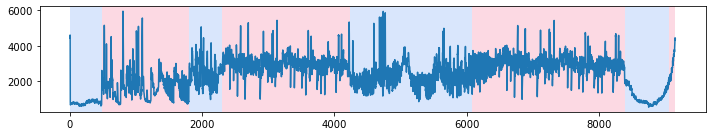

In [2]:
import matplotlib.pyplot as plt 
import ruptures as rpt  

signal = cent
signal = signal.T

# detection
algo = rpt.Dynp(model="l2").fit(signal)
result = algo.predict(n_bkps=7)

print(result)

# display segmentation
rpt.display(signal,  result)
plt.show()

## segmentation extract

In [3]:
pre_section = result
section=[]
for i in range(len(pre_section)):
    section.append(pre_section[i]//40)

## face detection

In [14]:
import pygame
pygame.init() 
pygame.mixer.music.load( './Faded_Alan Walker.mp3' )
import time

import cv2
import numpy as np   
#from keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import img_to_array
from keras.models import load_model

# Face detection XML load and trained model loading
face_detection = cv2.CascadeClassifier('models/haarcascade_frontalface_default.xml')
emotion_classifier = load_model('models/emotion_model.hdf5', compile=False)
EMOTIONS = ["Angry" ,"Disgusting","Fearful", "Happy", "Sad", "Surpring", "Neutral"]

# Video capture using webcam
camera = cv2.VideoCapture(0)

prev_time = 0
prev_point =0
FPS = 10

while True:
    # Capture image from camera
    ret, frame = camera.read()
    
    # Convert color to gray scale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Face detection in frame
    faces = face_detection.detectMultiScale(gray,
                                            scaleFactor=1.1,
                                            minNeighbors=5,
                                            minSize=(30,30))
    
    # Create empty image
    canvas = np.zeros((250, 300, 3), dtype="uint8")
    
    # Perform emotion recognition only when face is detected
    if len(faces) > 0:
        # For the largest image
        face = sorted(faces, reverse=True, key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
        (fX, fY, fW, fH) = face
        # Resize the image to 48x48 for neural network
        roi = gray[fY:fY + fH, fX:fX + fW]
        roi = cv2.resize(roi, (64, 64))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)
        
        # Emotion predict
        preds = emotion_classifier.predict(roi)[0]
        emotion_probability = np.max(preds)
        label = EMOTIONS[preds.argmax()]
        
        
        # Assign labeling
        cv2.putText(frame, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
        cv2.rectangle(frame, (fX, fY), (fX + fW, fY + fH), (0, 0, 255), 2)
 
        # Label printing
        for (i, (emotion, prob)) in enumerate(zip(EMOTIONS, preds)):
            text = "{}: {:.2f}%".format(emotion, prob * 100)    
            w = int(prob * 300)
            cv2.rectangle(canvas, (7, (i * 35) + 5), (w, (i * 35) + 35), (0, 0, 255), -1)
            cv2.putText(canvas, text, (10, (i * 35) + 23), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (255, 255, 255), 2)
    
    current_time = time.time() - prev_time
    
    if (ret is True) and (current_time > 10./ FPS) :
        prev_time = time.time()
        # playing music
        if preds.argmax() == 4:#sad
            point = 0
        elif preds.argmax() == 0 or preds.argmax() == 1 or preds.argmax() == 2:#angry,disgusting,fearful
            point = section[1]
        elif preds.argmax() == 3 or preds.argmax() == 5:# happy,surprising
            point = section[2]
        elif preds.argmax() == 6:# Neutral
            point = section[3]
        
        if point != prev_point:
            pygame.mixer.music.play(loops=0, start=point)
        prev_point = point
        
    # Open two windows
    ## Display image ("Emotion Recognition")
    ## Display probabilities of emotion
    cv2.imshow('Emotion Recognition', frame)
    cv2.imshow("Probabilities", canvas)
    
    # q to quit
    if cv2.waitKey(1) & 0xFF == ord('q'): 
        break

# Clear program and close windows
pygame.mixer.music.stop()
camera.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step
